In [1]:
using Pkg

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "TissueRigidity"
 
projectname()

"TissueRigidity"

In [2]:
using DifferentialEquations
using StatsBase
using CairoMakie
using XLSX
using DataFrames
using Optimization, OptimizationPolyalgorithms, SciMLSensitivity,OptimizationOptimJL,OptimizationBBO,OptimizationNOMAD

┌ Warning: Error requiring `Enzyme` from `LinearSolve`
│   exception = (LoadError("/Users/boothh/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveEnzymeExt.jl", 1, ArgumentError("Package LinearSolve does not have Enzyme in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added Enzyme as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011c7907cc, Ptr{Nothing} @0x000000011c790a16, Ptr{Nothing} @0x000000010944f6bd, Ptr{Nothing} @0x0000000109486a6d, Ptr{Nothing} @0x000000010948584f, Ptr{Nothing} @0x0000000109486039, Ptr{Nothing} @0x0000000109485cad, Ptr{Nothing} @0x0000000109486ef5, Ptr{Nothing} @0x0000000125d0ec41, Ptr{Nothing} @0x0000000109

In [3]:
include(srcdirx("Plotting&Utility.jl"))
include(srcdirx("FittingFunctions.jl"))
# include(srcdirx("old/FittingFunctions_old_cmax.jl"))

include(srcdirx("NodalLefty_E.jl"))

exp_name = "NodalLefty_RelayDiffusion_v2"

include(srcdirx("ExperimentSetups/" * exp_name * ".jl"))

include(scriptsdirx("LoadData.jl"));

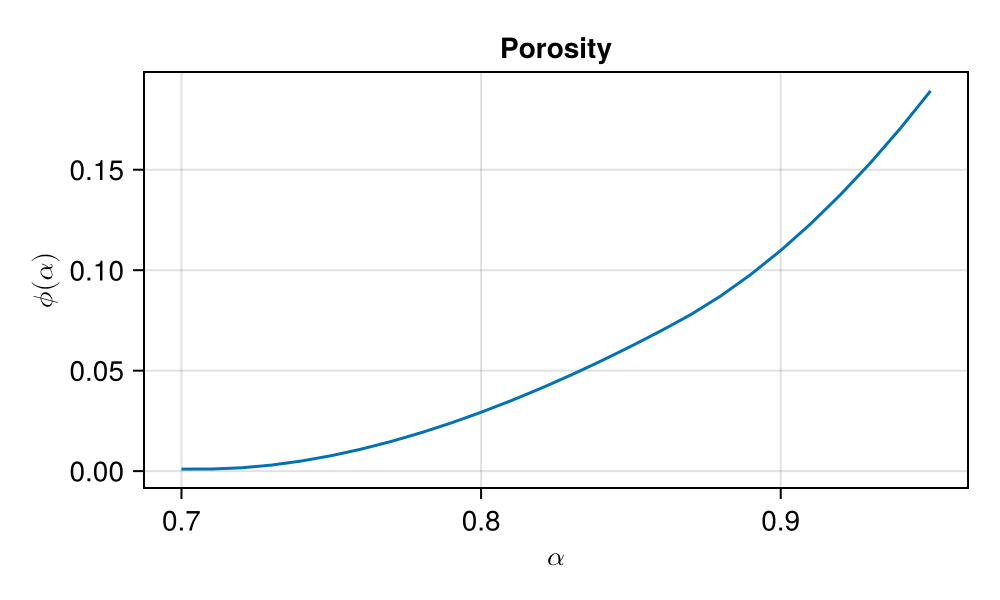

In [4]:
α_range = 0.7:0.01:0.95

fig = Figure(size = (500,300))
ax1 = Axis(fig[1,1],title = "Porosity",ylabel = L"\phi(\alpha)",xlabel = L"\alpha")

lines!(ax1, α_range,[ϕ(α) for α in α_range])

fig

In [5]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]
# pv_orig = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_OptParmas.jld2")["OptimalParam"][3]

p_orig,p_cp_orig,p_lm_orig = get_params(pv_orig)

tspan = (0,Inf)

u0 = ones(Nc,4)

u0[:,1] .= 1e-10
u0[:,2] .= 1e-10
u0[:,3] .= 0.
u0[:,4] .= α0

prob = ODEProblem(nodal_lefty_spatial_diff!,u0,tspan,p_orig)

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

lb[3:end] = (1 - γ) .* lb[3:end]
ub[3:end] = (1 + γ) .* ub[3:end];

In [6]:
orig_metrics = get_summary_metrics(pv_orig,prob,data,alpha_data,0.2)

(wt_t0 = 771.1860505789947, cp_t0 = 1542.3721011579894, wt_xMax = 42.14046822742475, cp_xMax = 85.28428093645485, lm_xMax = 45.1505016722408, wt_d0 = 0.11904761904761905, cp_d0 = 0.3764705882352941, lm_d0 = 0.11111111111111112, xmax_peak_ratio = 2.0, xmax_mse = (0.16184003872539304, 0.6074757966215868), xmax_mse_half = (0.16184003872539304, 0.062048722440075796), alpha_mse = 0.005546927989503856, cp_lprod_t0 = 771.1860505789947, wt_lprod_t0 = 578.3895379342459, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

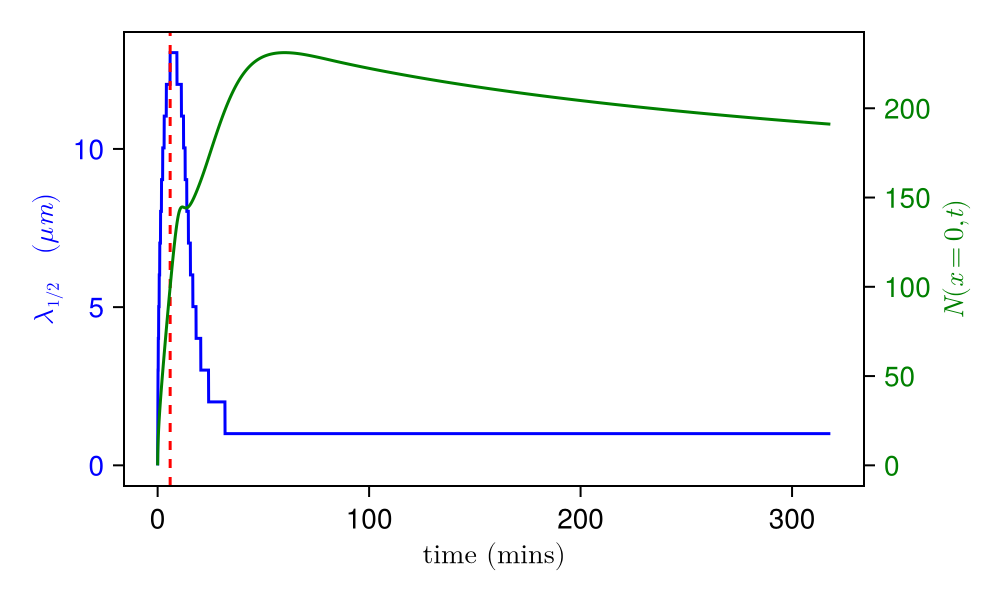

In [9]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_N)

sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

N_samp = 5000

λ_trange = LinRange(0.,sol.t[end],N_samp)

N0t = [sol(t)[1,1] for t in λ_trange]

λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

c_max = maximum(sol(λhalf_max_t)[:,1])

lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT.pdf"),fig)

fig

In [10]:
fig = Figure(size = (1000,1000))

fig = plot_summary!(fig,[DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0],prob)

save(plotsdir(exp_name * "/OrigFits/Summary_orig.pdf"),fig)

fig


CairoMakie.Screen{PDF}


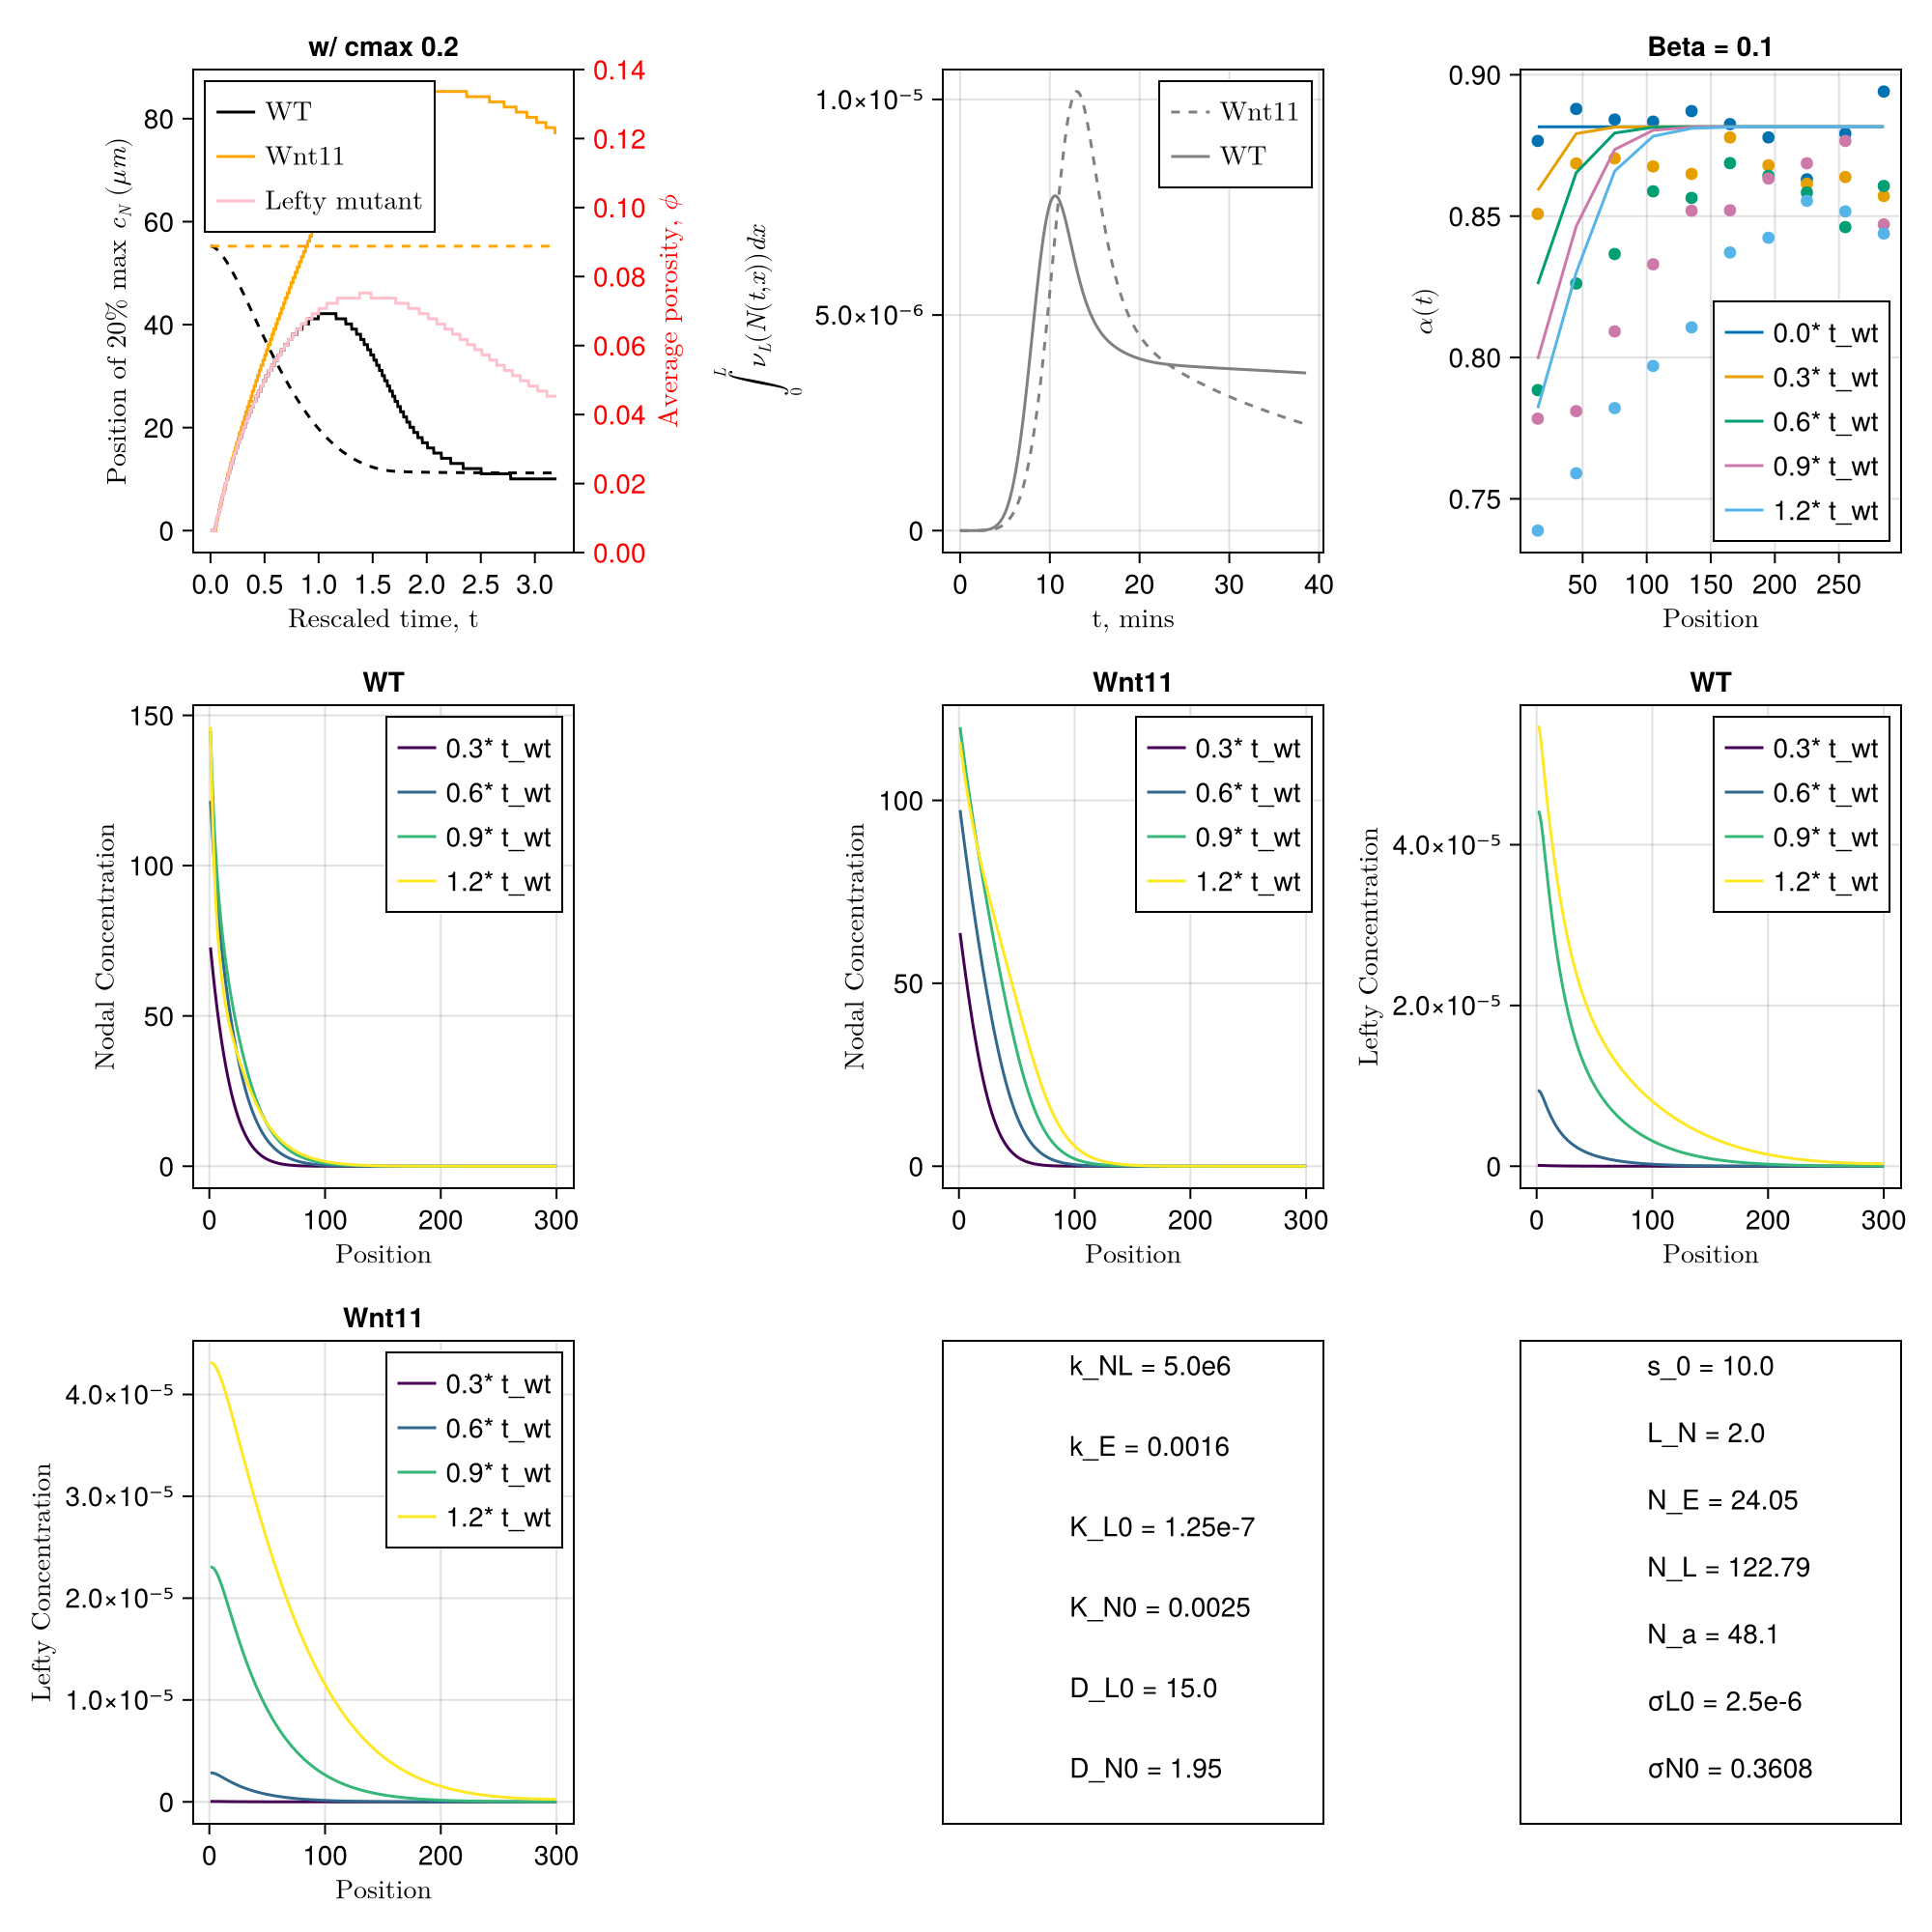

In [11]:
fig

In [13]:
γ = 0.99

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

# knl , sigma_n not large enough

lb[3:end] = 0.5 .* lb[3:end]
ub[3:end] = 2 .* ub[3:end];

lb[6] = 1.
ub[6] = 500.

j = 1.

lb_pow = copy(pv_orig)
ub_pow = copy(pv_orig)

lb_pow[1:2] = 0.9 .* lb_pow[1:2]
ub_pow[1:2] = 1.1 .* ub_pow[1:2]

lb_pow[3:end] = 10^(-j) .* lb_pow[3:end]
ub_pow[3:end] = 10^(j) .* ub_pow[3:end];

# lb_pow[6] = 50.
# ub_pow[6] = 1000

lb_pow[end] = 4.99
ub_pow[end] = 5.01

# lb_pow1 = vcat(lb_pow1,[0.1])
# ub_pow1 = vcat(ub_pow1,[0.3])

5.01

In [14]:
pv_start = copy(pv_orig)

# pv_start[6] = 75.

# pv_start1 = vcat(pv_start,[0.2])

check_inbounds(pv_start,lb_pow,ub_pow)

# check_inbounds(pv_start1,lb_pow1,ub_pow1)

(true, Any[])

In [15]:
ro,obj = optimize_params(prob,0.2,pv_start,lb_pow,ub_pow,100,false,true)

BBE OBJ
1   0.117491


26   0.085023


In [ ]:
ro_tuple,ro_cp_tuple,ro_lm_tuple = get_params(ro)

In [ ]:
fig = Figure(size = (1200,1000))

fig = plot_summary!(fig,[ro_tuple[:DN0],ro_tuple[:DL0],ro_tuple[:kN0],ro_tuple[:kL0],ro_tuple[:kE],ro_tuple[:kNL],ro_tuple[:σN0],ro_tuple[:σL0],ro_tuple[:Na],ro_tuple[:NL],ro_tuple[:NE],ro_tuple[:LN],ro_tuple[:s0]],prob)

fig

In [199]:
save(plotsdir(exp_name * "/OptFits/Summary_Opt_P1.pdf"),fig)

save(exp_name * "OptParamDiff.jld2",Dict("param"=>ro_tuple))


CairoMakie.Screen{PDF}


In [182]:
sim_data = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_CPSet_Sweep_RestrID.jld2")["Results"];
sim_data_p = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_CPSet_Sweep_RestrID.jld2")["Parameters"];

In [183]:
argmin(map(x->minimum([y[:wt_d0] for y in x]),sim_data))

6455

In [188]:
sim_tuple, _,_ = get_params(sim_data_p[6455])

((DN0 = 1.95, DL0 = 15.0, kN0 = 1.5194850483459551e-6, kL0 = 7.465310302629284e-7, kE = 0.00028852347539516876, kNL = 10.303407667201299, σN0 = 0.01, σL0 = 0.00620518038929364, Na = 31.6228, NL = 181.38301582100422, NE = 12.316816453909029, mN = 2, mL = 8, mNL = 2, LN = 19.150715022082355, s0 = 5.0), (DN0 = 1.95, DL0 = 15.0, kN0 = 1.5194850483459551e-6, kL0 = 7.465310302629284e-7, kE = 0.00028852347539516876, kNL = 10.303407667201299, σN0 = 0.01, σL0 = 0.00620518038929364, Na = 31.6228, NL = 181.38301582100422, NE = 1.0e8, mN = 2, mL = 8, mNL = 2, LN = 19.150715022082355, s0 = 5.0), (DN0 = 1.95, DL0 = 15.0, kN0 = 1.5194850483459551e-6, kL0 = 7.465310302629284e-7, kE = 0.00028852347539516876, kNL = 0.0, σN0 = 0.01, σL0 = 0.00620518038929364, Na = 31.6228, NL = 181.38301582100422, NE = 12.316816453909029, mN = 2, mL = 8, mNL = 2, LN = 19.150715022082355, s0 = 5.0))

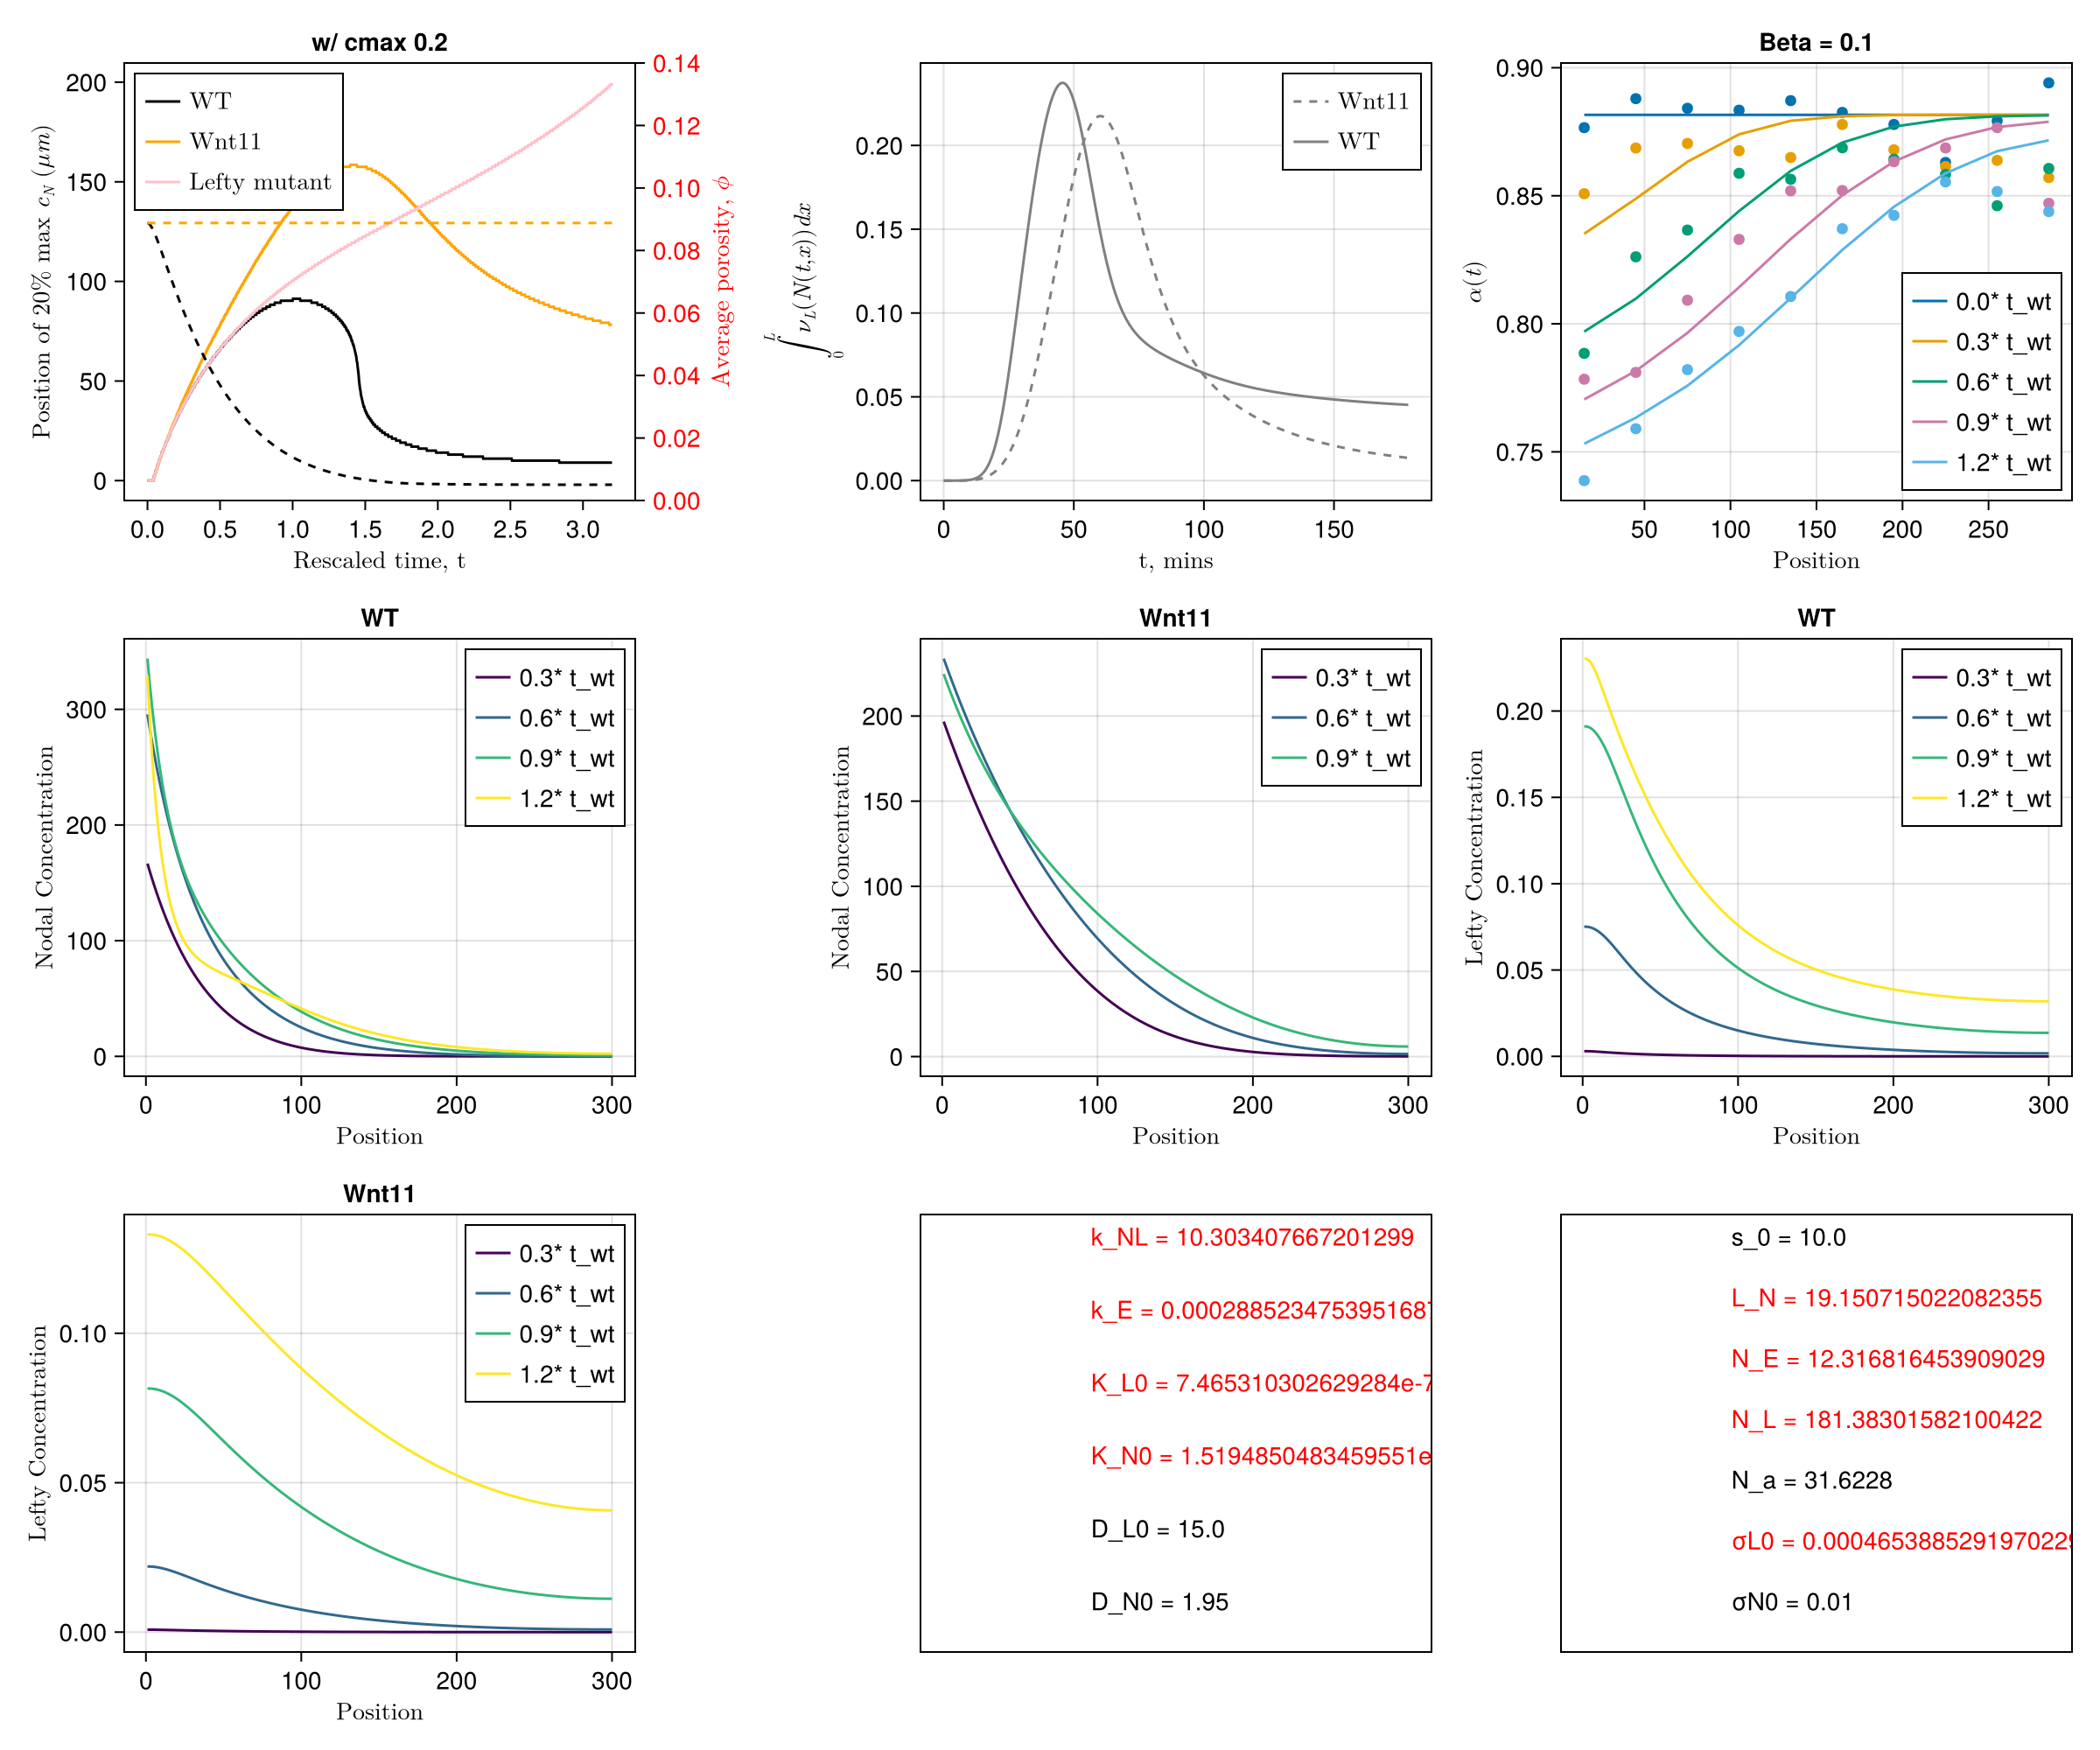

In [200]:
fig = Figure(size = (1200,1000))

fig = plot_summary!(fig,[sim_tuple[:DN0],sim_tuple[:DL0],sim_tuple[:kN0],sim_tuple[:kL0],sim_tuple[:kE],sim_tuple[:kNL],sim_tuple[:σN0],0.075*sim_tuple[:σL0],sim_tuple[:Na],sim_tuple[:NL],sim_tuple[:NE],sim_tuple[:LN],sim_tuple[:s0]],prob)

fig

In [202]:
save(plotsdir(exp_name * "/OptFits/Summary_Sweep_P1.pdf"),fig)

CairoMakie.Screen{PDF}


In [215]:
fig = Figure(size = (1200,1000))

de_abstol = 1e-11
de_reltol = 1e-9

fig = plot_summary!(fig,[sim_tuple[:DN0],sim_tuple[:DL0],sim_tuple[:kN0],sim_tuple[:kL0],sim_tuple[:kE],sim_tuple[:kNL],sim_tuple[:σN0],0.075*sim_tuple[:σL0],sim_tuple[:Na],sim_tuple[:NL],sim_tuple[:NE],sim_tuple[:LN],0.5*sim_tuple[:s0]],prob)

fig

"Numerical instability. Increase abstol/reltol"

In [59]:
sol = solve(prob, p = p_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_lm = solve(prob, p = p_cp_opt, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_cp = solve(prob, p = p_lm_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

In [60]:
(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm_rescaled )),(porosity_dyn,porosity_dyn_cp),c_level,(sol,sol_cp,sol_lm) = get_alpha_xmax_lambda(pv_orig,prob,0.2);

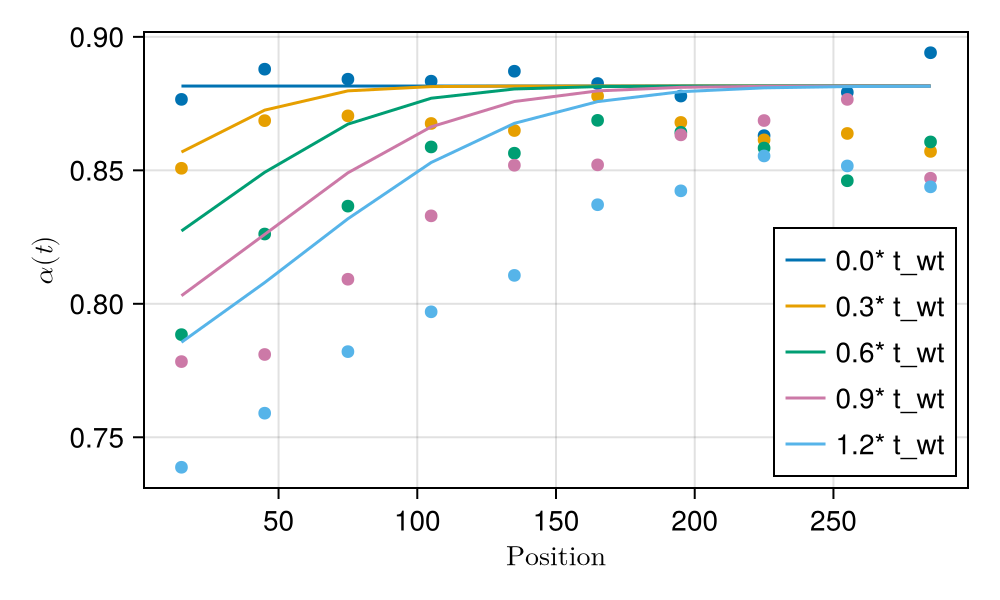

In [61]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"α(t)" )

for (n,d) in enumerate(dyn_alpha)
    lines!(ax,alpha_x,d, label = string(alpha_data_times_norm[n])* "* t_wt")
    scatter!(ax,alpha_x,alpha_data[:,n+1])
end

axislegend(ax,position = :rb)

save(plotsdir(exp_name * "/OptFits/Alpha_over_time.pdf"),fig)

fig

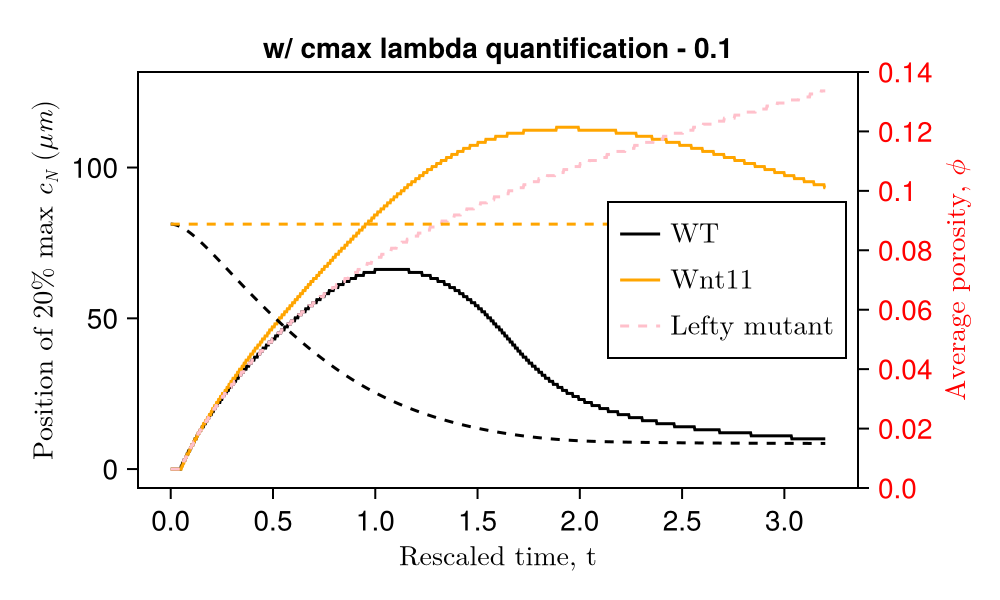

In [65]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false,title = "w/ cmax lambda quantification - 0.1")
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

lines!(ax,t_plot,level_x_wt_rescaled,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled,color = :orange,label = L"\text{Wnt11}")
lines!(ax,t_plot,level_x_lm_rescaled,linestyle = :dash,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# lines!(ax,exp_times_times_norm ,data[:,"SLB"],color = :blue)
# lines!(ax,exp_times_times_norm ,data[:,"WT"],color = :black)

axislegend(ax,position = :rc)

ylims!(ax_por,0.,0.14)
# ylims!(ax,0.,300)
ax.xticks = (0:0.5:3.5,string.(0:0.5:3.5))

ax_por.yticks = (0:0.02:0.14,string.(0:0.02:0.14))

save(plotsdir(exp_name * "/OptFits/Fig3E_xmax_over_time.pdf"),fig)

# (DN0 = 1.945, DL0 = 14.98, kN0 = 1.25e-7, kL0 = 7.6e-7, kE = 0.00051, kNL = 9.99, σN0 = 0.1, σL0 = 0.0012, Na = 316.228, NL = 1000.0, NE = 23.61709999999997, mN = 2, mL = 8, mNL = 2, LN = 1.58114, s0 = 28.0)

fig

In [66]:
p_opt

(DN0 = 1.945, DL0 = 14.98, kN0 = 1.25e-7, kL0 = 7.6e-7, kE = 0.00051, kNL = 9.99, σN0 = 0.1, σL0 = 0.0012, Na = 316.228, NL = 1000.0, NE = 23.61709999999997, mN = 2, mL = 8, mNL = 2, LN = 1.58114, s0 = 28.0)

In [ ]:
safesave("OptimizationRuns/" * exp_name * ".jld2", Dict("Params"=>ro,"Obj" => obj))

In [ ]:
# to_plot = [:wt_t0,:cp_t0,:xmax_peak_ratio,:wt_xMax,:cp_xMax,:wt_d0,:cp_d0,:lm_d0,:alpha_mse]

# fig = Figure(size = (760,760))

# grid_ax = Tuple.(findall(x->x>0,ones(3,3)))

# for (n,metric) in enumerate(to_plot)
#     if metric  == :alpha_mse
#         ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric],xscale = log10)
#         hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6),bins = 50)
#         vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash)
#         vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash)
#     else
#         ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric])
#         hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6))
#         vlines!(ax,transformations[metric](data_metrics[metric]),color = :red,linestyle = :dash, label = L"\text{Experiment}")
#         vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash, label = L"\text{Start param.}")
#         vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash, label = L"\text{Opt param.}")
#     end

#     if metric == :xmax_peak_ratio
#         axislegend(ax,position = :rt)
#     end

# end

# save(plotsdir(exp_name * "/OptFits/Summary_metrics.pdf"),fig)

# fig

In [ ]:
ro_pow,obj_pow = optimize_params(prob,0.1,pv_orig,lb_pow,ub_pow,200)

In [ ]:
p_opt